In [50]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato_dataset",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True
 )

Found 2152 files belonging to 3 classes.


In [4]:
classes_name  = dataset.class_names
classes_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
#it shows 68 because 32 set of images are created as batches 2152 total make 67.25 batches 
len(dataset)

68

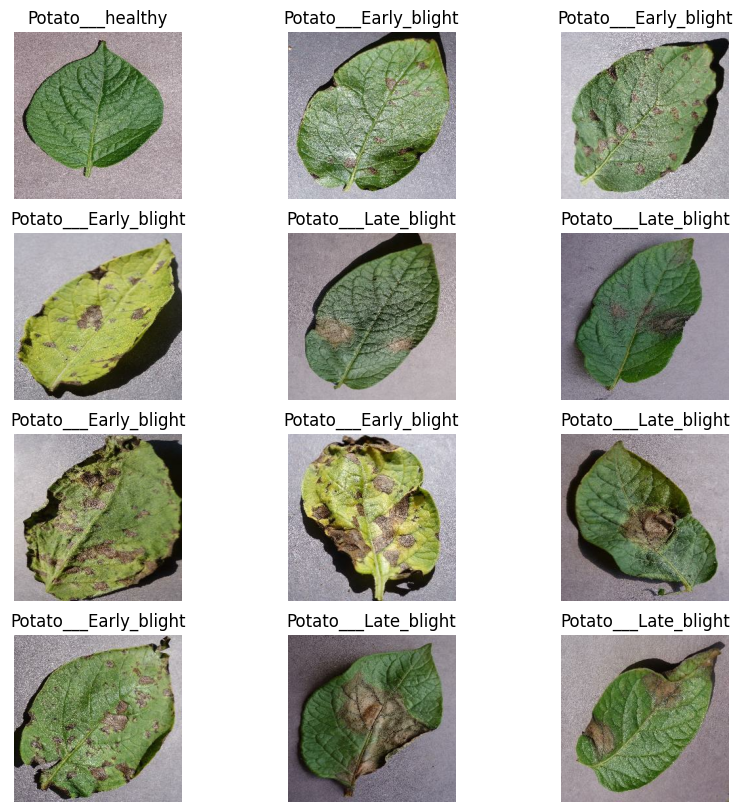

In [6]:
plt.figure(figsize=(10,10))
for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(classes_name[labels[i]])
    

In [7]:
train_size = 0.8
training_batch_size=int(len(dataset)*0.8)


In [8]:
training_dataset = dataset.take(training_batch_size)
len(training_dataset)



54

In [9]:
test_dataset = dataset.skip(54)
len(test_dataset)


14

In [10]:
val_size = 0.1
val_dataset = test_dataset.take(6)
len(val_dataset)

6

In [11]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [12]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    if shuffle :
        ds = ds.shuffle(shuffle_size,seed=12)
        
    training_batch_size=int(len(ds)*train_split)
    val_batch_size=int(len(ds)*val_split)
        
    train_ds = dataset.take(training_batch_size)
    val_ds = dataset.skip(training_batch_size).take(val_batch_size)
    test_ds = dataset.skip(training_batch_size).skip(val_batch_size)
    return train_ds,val_ds,test_ds 

In [13]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [14]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


In [17]:
input_shape = (32,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
    )


In [20]:
history = model.fit(train_ds,epochs=50,batch_size = BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.4363 - loss: 0.9573 - val_accuracy: 0.3958 - val_loss: 0.8789
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.6399 - loss: 0.7939 - val_accuracy: 0.6823 - val_loss: 0.6879
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.7972 - loss: 0.4682 - val_accuracy: 0.8073 - val_loss: 0.4781
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.8521 - loss: 0.3590 - val_accuracy: 0.8750 - val_loss: 0.2893
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.9066 - loss: 0.2565 - val_accuracy: 0.9323 - val_loss: 0.1657
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.9185 - loss: 0.1901 - val_accuracy: 0.8333 - val_loss: 0.4512
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8850 - loss: 0.2588 - val_accuracy: 0.9479 - val_loss: 0.1726
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.9499 - loss: 0.1435 - val_accuracy: 

In [22]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9735 - loss: 0.0713


True Value :  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Value : Potato___Late_blight


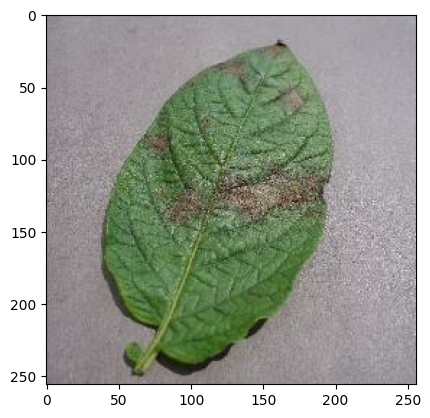

In [55]:
for image_labels , batch_labels in test_ds.take(1):
    first_image =(image_labels[0].numpy().astype("uint8"))
    first_label = classes_name[batch_labels[0]]
    print(f"True Value :  {first_label}")
    plt.imshow(first_image)
    predictions = model.predict(image_labels)
    print(f'Predicted Value : {classes_name[np.argmax(predictions[0])]}')

In [68]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = classes_name[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class , confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


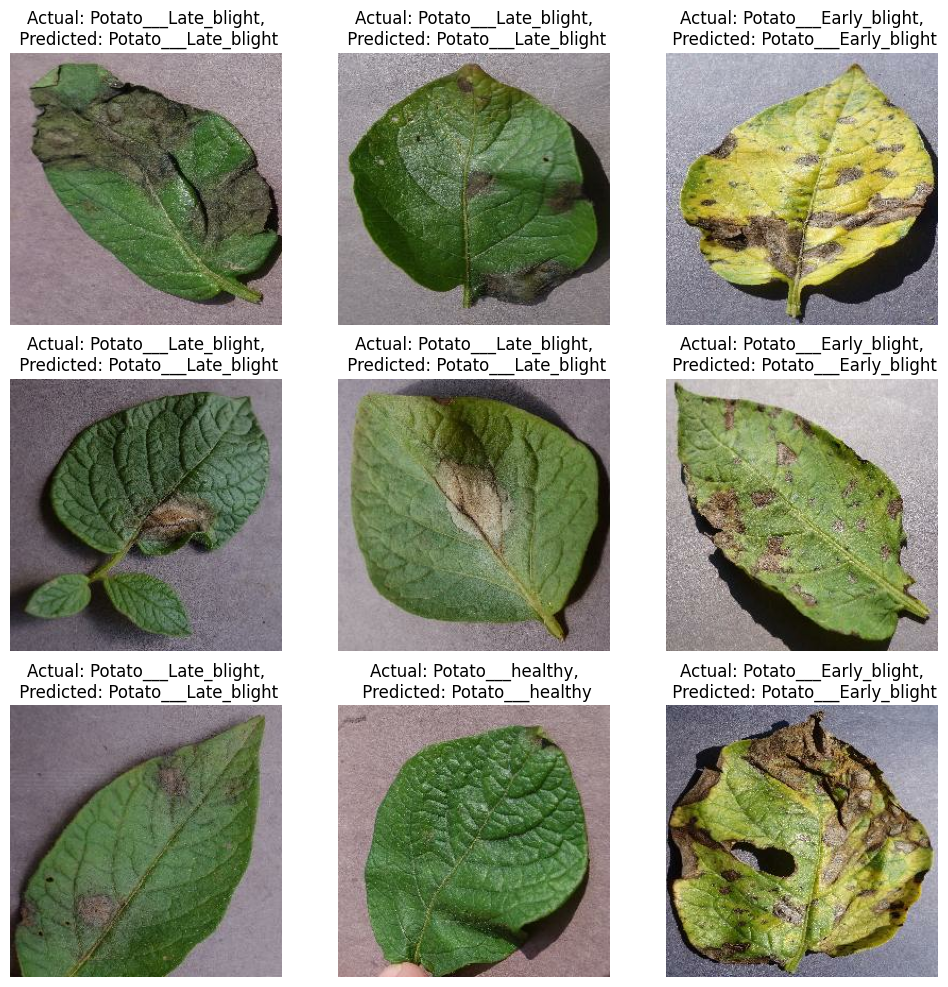

In [75]:
plt.figure(figsize = (12,12))
for images , labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class , confidence  = predict(model,images[i].numpy())
        actual_class = classes_name[labels[i]]
        plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class}')
        plt.axis('off')
        

In [88]:
model_version = 1
model.save(f'C:\\Users\\User\\Desktop\\Reena\\Potato_Disease_Identifier\\models\\model_v{model_version}.h5')


['model_v1.h5']